In [ ]:
import geopandas as gpd
import rasterio
import os
import mapas_raster
import matplotlib.pyplot as plt
import functions

In [ ]:
#Import the data
#from google.colab import drive
#drive.mount('/content/drive')
geoinfo_path = '/Users/Daniel/Library/CloudStorage/OneDrive-VestigiumMétodosMixtosAplicadosSAS/geoinfo/'
gdp_path = os.path.join(geoinfo_path, 'Internacionales/gdp_new/rast_gdpTot_1990_2020_30arcsec.tif')
colab_path = '/Users/Daniel/Library/CloudStorage/GoogleDrive-dwiesner@metodosmixtos.com/My Drive/Colab Notebooks/'
panel_path = os.path.join(colab_path, 'bayesian-predictions/data/KHM/panel/panel-khm-02082024-v2.shp')
gdf = gpd.read_file(panel_path)
gdf = gdf.to_crs(epsg=4326)

#### New GDP estimates:
- The come from this paper: https://www.nature.com/articles/s41597-025-04487-x
- Data can be downloaded here: https://zenodo.org/records/13943886


Grids for total GDP:

Resolution: 30 arc-sec

Spatial extent: Lon: -180, 180; -90, 90 (xmin, xmax, ymin, ymax)

Coordinate ref system: EPSG:4326 - WGS 84

Format: Multiband geotiff; each band for each year over 1990-2022 (5 arc-min, 30 arc-min) or for each five years 1990, 1995, ... 2015, 2020 (30 arc-sec)

Unit: USD in 2017 international dollars

In [ ]:
#Find the old estimates
gdp_columns = [g for g in gdf.columns if 'gdp' in g.lower()]

In [ ]:
gdf = gdf.drop(gdp_columns, axis=1)

In [ ]:
#Load a raster and explore the information that it has

# Replace 'path/to/your/raster.tif' with the actual path to your raster file
raster_path = gdp_path

gdp_bands = {
    1: "gdp_1990",
    2: "gdp_1995",
    3: "gdp_2000",
    4: "gdp_2005",
    5: "gdp_2010",
    6: "gdp_2015",
    7: "gdp_2020"
}

In [ ]:
#Add a column for each gdp year
for band in gdp_bands:

    s = mapas_raster.get_zonal_stats(panel_path,
                             raster_path,
                             'sum',
                             gdp_bands[band],
                             band=band)
    print(f'{gdp_bands[band]} calculated.')

    gdf = mapas_raster.add_column_to_gdf(gdf, s)


gdp_1990 calculated.
gdp_1995 calculated.
gdp_2000 calculated.
gdp_2005 calculated.
gdp_2010 calculated.
gdp_2015 calculated.
gdp_2020 calculated.


In [ ]:
gdp_columns = [g for g in gdf.columns if 'gdp' in g.lower()]
#Values in thousands of dollars
#for i in gdp_columns:
    #gdf[i] = gdf[i]/1000

In [ ]:
new_panel_path = os.path.join(colab_path, 'bayesian-predictions/data/KHM/panel/panel-khm-02082024-v3.shp')
#gdf.to_file(new_panel_path)

In [ ]:
gdf = gpd.read_file(new_panel_path)

In [ ]:
gdp_columns = [g for g in gdf.columns if 'gdp' in g.lower()]

### Gráficas

### Drop urban areas

To identify urban zones we use:

- Global Human Settlement Layer (GHSL) by the European Commission:
	•	The GHSL produces global maps of urban areas based on satellite imagery and other data.
- We are using: GHS-SMOD
- https://human-settlement.emergency.copernicus.eu/ghs_smod2023.php

In [ ]:
country = 'KHM'
data_folder = '/Users/Daniel/Library/CloudStorage/GoogleDrive-dwiesner@metodosmixtos.com/My Drive/Colab Notebooks/bayesian-predictions/data'

In [ ]:
#Paths

urban_layer_raster = os.path.join(data_folder, 'Global/GHS_SMOD_E2030_GLOBE_R2023A_54009_1000_V2_0/GHS_SMOD_E2030_GLOBE_R2023A_54009_1000_V2_0.tif')
country_bounds = os.path.join(data_folder, country, 'country_boundary/country_bounds.shp')
cropped_urban_layer_raster = 'temp_files/urban_layer.tiff'
report_folder = 'temp_files/report'

#Folder for temporary files
os.makedirs('temp_files', exist_ok=True)
os.makedirs(report_folder, exist_ok=True)

In [ ]:
ust = 25 # (o to 30) 0 is a totally unpopulated pixel and 30 is a totally urban pixel
#Crop the global urban areas raster to the area of the Country of interest
functions.raster_clipping(country_bounds, urban_layer_raster, cropped_urban_layer_raster)
urban_mask = functions.generate_urban_mask(cropped_urban_layer_raster, ust, 'temp_files/urban_mask_polygons.shp')
#Clip the urban areas out of the main df
gdf = functions.inverted_clip_touching_gdf(gdf, urban_mask)

Reprojecting shapefile from EPSG:4326 to ESRI:54009


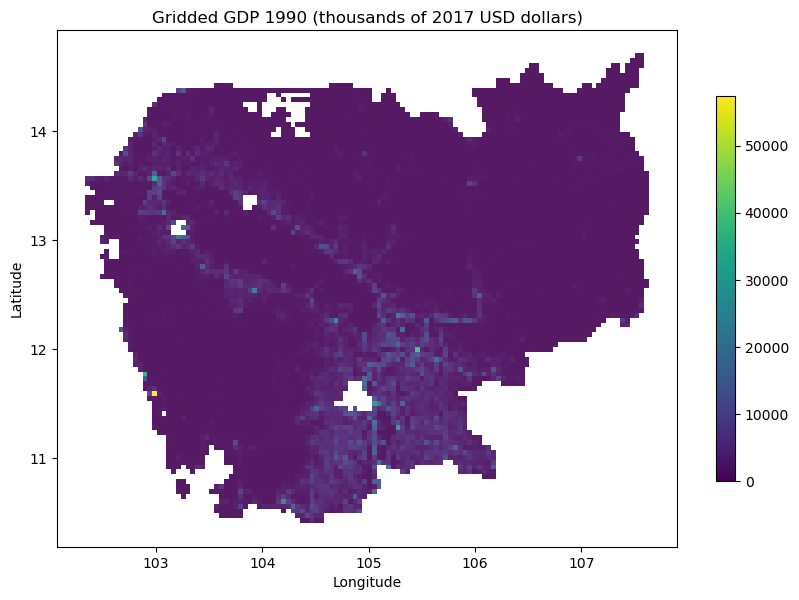

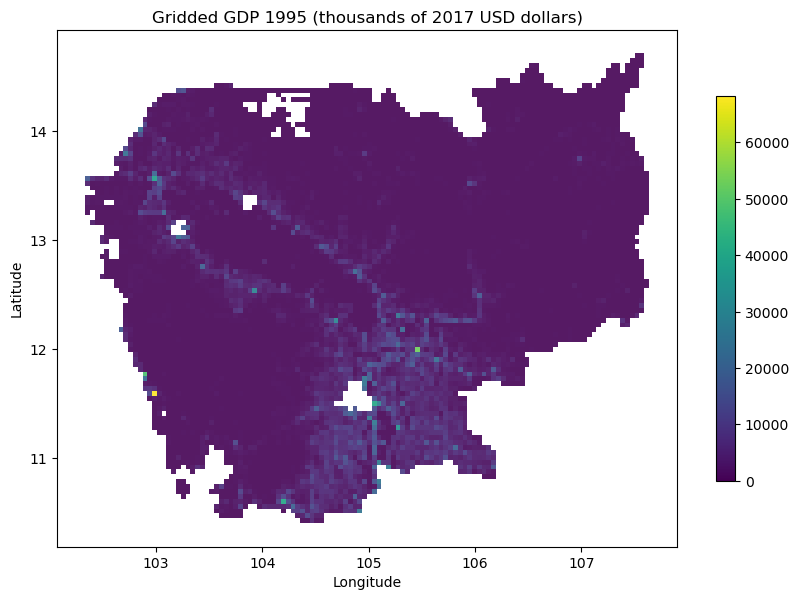

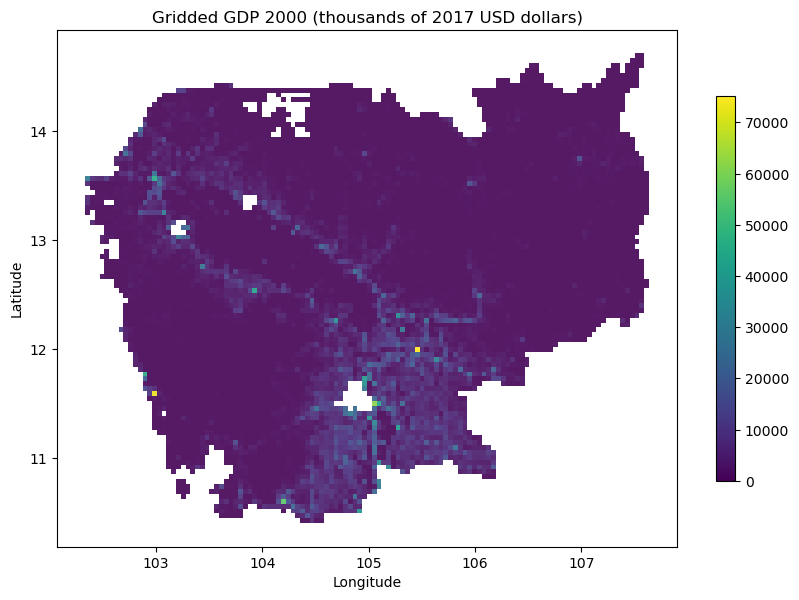

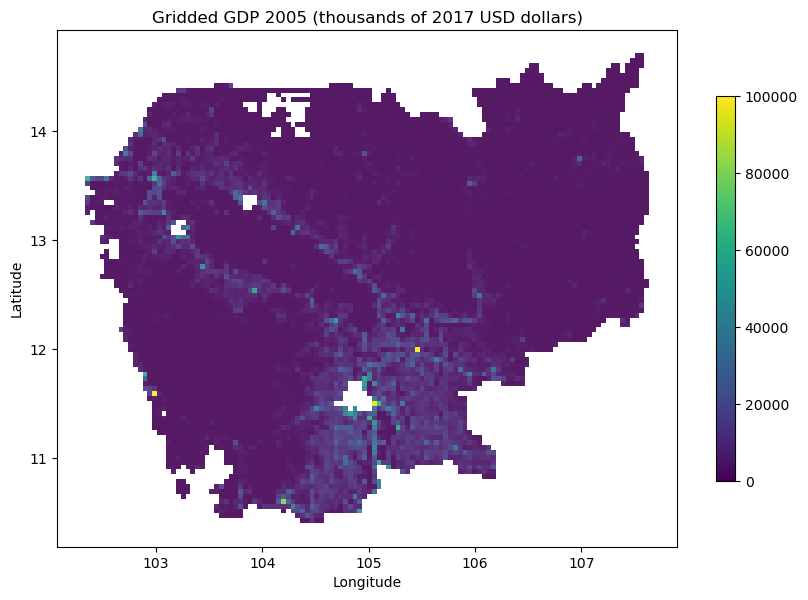

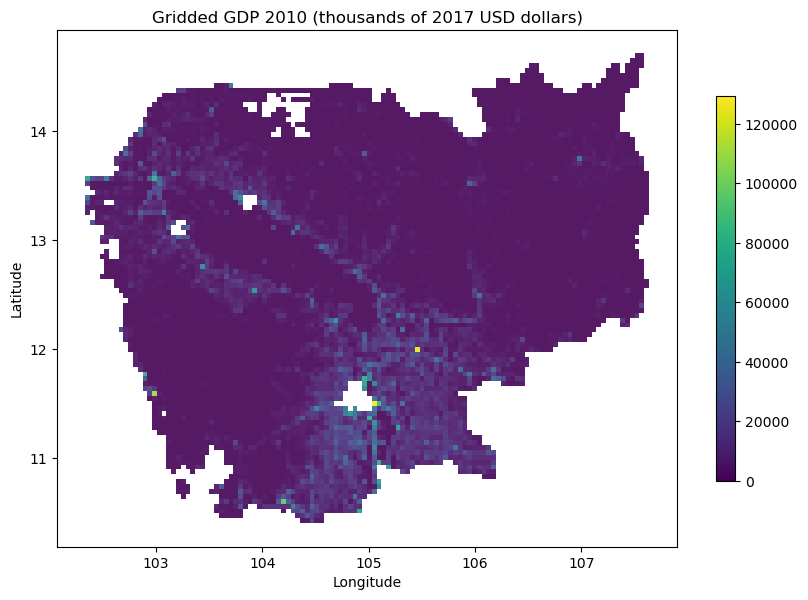

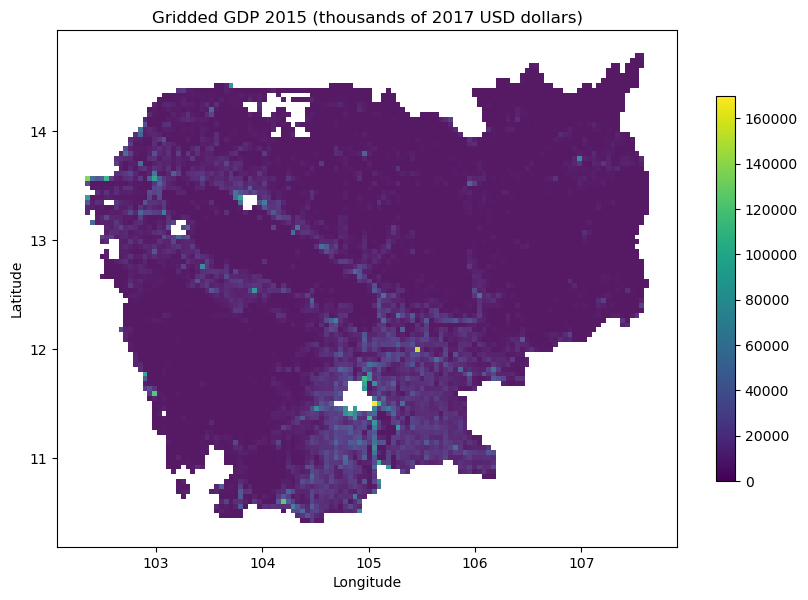

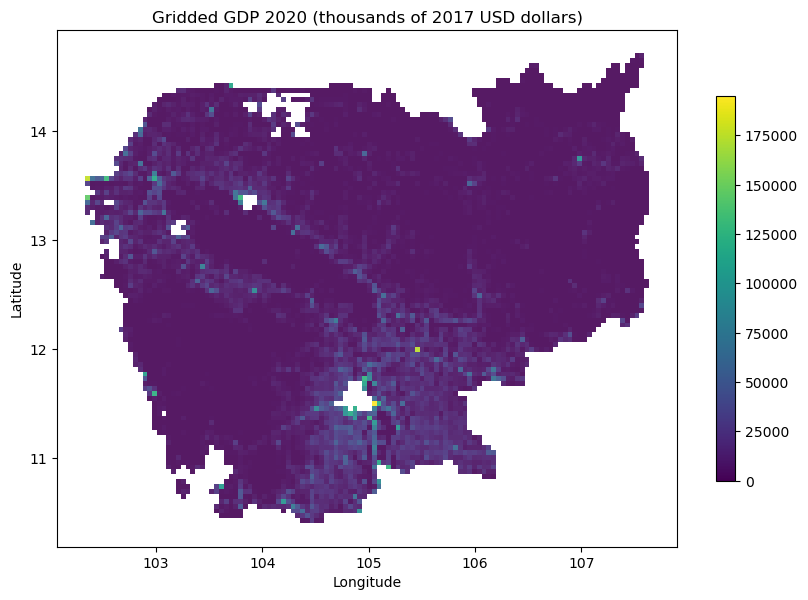

In [ ]:
for i in gdp_columns:

    # Create a plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the GeoDataFrame with a colormap based on the target_indicator
    gdf.plot(ax=ax, column=i, cmap='viridis', alpha=0.8)

    # Customize the plot (optional)
    ax.set_title(f'Gridded GDP {i[-4:]} (thousands of 2017 USD dollars)')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Plot again with a legend
    gdf_plot = gdf.plot(ax=ax, column=i, cmap='viridis', alpha=0.5)

    # Add a color bar
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=gdf[i].min(), vmax=gdf[i].max()))
    sm._A = []  # Create an empty array for the scalar mappable
    cbar = fig.colorbar(sm, ax=ax, shrink=0.5)  # Adjust the 'shrink' parameter to reduce color bar size


    # Save the plot as a PDF
    plt.savefig(os.path.join('temp_files/report',
                             f'{country} -  {i[-4:]} - GDP.pdf'))

    plt.show()

### Adjust for inflation

In [ ]:
%%time
# Adjust inflation
df['GDP_PPP'] = df['GDP_PPP'].apply(lambda x: mapas_raster.adjust_for_inflation(x,
                                                                                2017,
                                                                                2022,
                                                                                paths['inflation_usa']))

CPU times: user 7.02 s, sys: 627 ms, total: 7.65 s
Wall time: 7.92 s
